In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np

## Load and inspect data

In [2]:
# Load and inspect the dataset
movie_df = pd.read_csv('data/preprocessed/subset_movie_with_full_data_on_lead_actors.csv')
print(movie_df.info())
movie_df[['movie_name', 'adjusted_box_office', 'averageRating']].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   wikipedia_movie_id   2232 non-null   int64  
 1   freebase_movie_id    2232 non-null   object 
 2   movie_name           2232 non-null   object 
 3   movie_release_date   2232 non-null   object 
 4   box_office_revenue   2232 non-null   float64
 5   runtime              2232 non-null   float64
 6   languages            2232 non-null   object 
 7   countries            2232 non-null   object 
 8   genres               2232 non-null   object 
 9   imdb_id              2232 non-null   object 
 10  averageRating        2232 non-null   float64
 11  numVotes             2232 non-null   float64
 12  lead_actor_1         2232 non-null   object 
 13  lead_actor_2         2232 non-null   object 
 14  release_year         2232 non-null   int64  
 15  adjusted_box_office  2232 non-null   f

,movie_name,adjusted_box_office,averageRating
0,ghosts of mars,2.323395e+07,4.9
1,baby boy,4.872314e+07,6.5
2,loverboy,9.468549e+06,6.1
3,star!,3.398327e+07,6.4
4,becoming jane,5.462201e+07,7.0


## Filter and Clean Data

In [3]:
cluster_data = movie_df[['adjusted_box_office', 'averageRating']].dropna()

# Ensure the data is numeric
cluster_data = cluster_data[(cluster_data['adjusted_box_office'] > 0) & (cluster_data['averageRating'] > 0)]

# Apply a log transformation to adjusted_box_office
cluster_data['log_adjusted_box_office'] = np.log1p(cluster_data['adjusted_box_office'])


cluster_data.head(2)

,adjusted_box_office,averageRating,log_adjusted_box_office
0,2.323395e+07,4.9,16.961125
1,4.872314e+07,6.5,17.701665


## Standardize the Features

In [4]:
# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data[['log_adjusted_box_office', 'averageRating']])

# Create a DataFrame for easier visualization
scaled_df = pd.DataFrame(scaled_data, columns=['log_adjusted_box_office', 'averageRating'])
scaled_df.head()


,log_adjusted_box_office,averageRating
0,-0.183182,-1.542466
1,0.183651,0.183619
2,-0.627836,-0.247902
3,0.005180,0.075739
4,0.240262,0.723020


## Determine the Optimal Number of Clusters

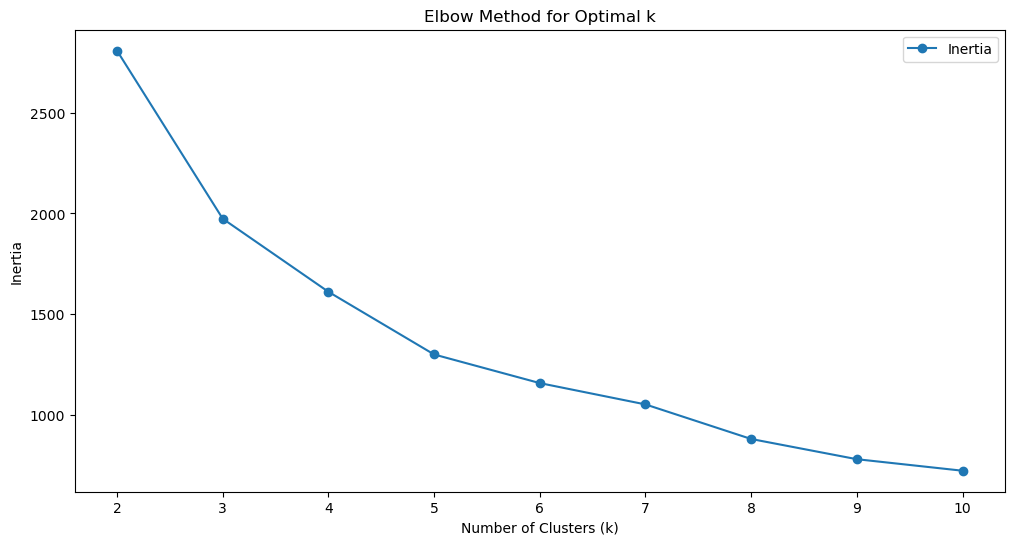

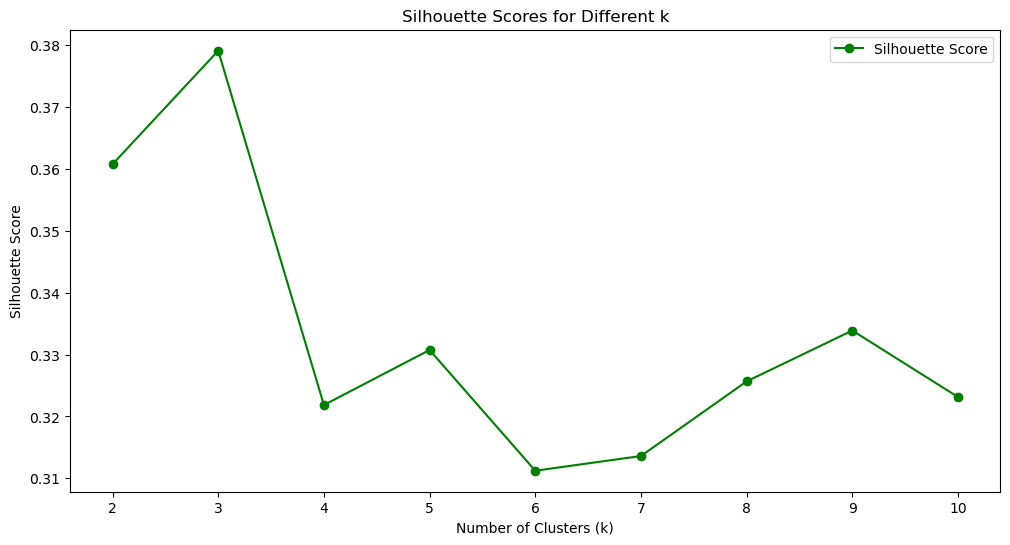

In [5]:
# Find the optimal number of clusters using the elbow method
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Plot the elbow method
plt.figure(figsize=(12, 6))
plt.plot(k_values, inertia, marker='o', label='Inertia')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(12, 6))
plt.plot(k_values, silhouette_scores, marker='o', label='Silhouette Score', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.legend()
plt.show()

Based on both plots we can see that K = 3 is the right value to chose as it has the highest Silhouette score and has a sort of "elbow" in the first plot

## Apply K-Means Clustering

In [6]:
# Choose the optimal number of clusters (adjust k based on the elbow method)
optimal_k = 3  # Replace with the chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original DataFrame
cluster_data['Cluster'] = cluster_labels
movie_df = movie_df.loc[cluster_data.index]
movie_df['Cluster'] = cluster_labels
movie_df.head()


,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,runtime,languages,countries,genres,imdb_id,averageRating,numVotes,lead_actor_1,lead_actor_2,release_year,adjusted_box_office,Cluster
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",tt0228333,4.9,58910.0,Natasha Henstridge,Ice Cube,2001,2.323395e+07,2
1,156558,/m/014k4y,baby boy,2001-06-27,29381649.0,123.0,['English'],['United States of America'],"['Crime Fiction', 'Drama', 'Coming of age']",tt0255819,6.5,17113.0,Alexsandra Wright,Tyrese Gibson,2001,4.872314e+07,1
2,12053509,/m/02vn81r,loverboy,1989-04-28,3960327.0,98.0,['English'],['United States of America'],"['Romantic comedy', 'Romance Film', 'Comedy']",tt0097790,6.1,8974.0,Patrick Dempsey,Kate Jackson,1989,9.468549e+06,2
3,7767613,/m/026ccts,star!,1968-07-18,4000000.0,176.0,['English'],['United States of America'],"['Biography', 'Musical', 'Drama', 'Biopic [fea...",tt0063642,6.4,2305.0,Julie Andrews,Richard Crenna,1968,3.398327e+07,1
4,3033993,/m/08m1s2,becoming jane,2007-03-02,37311672.0,112.0,['English'],"['Ireland', 'United Kingdom']","['Biography', 'Costume drama', 'Period piece',...",tt0416508,7.0,66040.0,Anne Hathaway,James McAvoy,2007,5.462201e+07,1


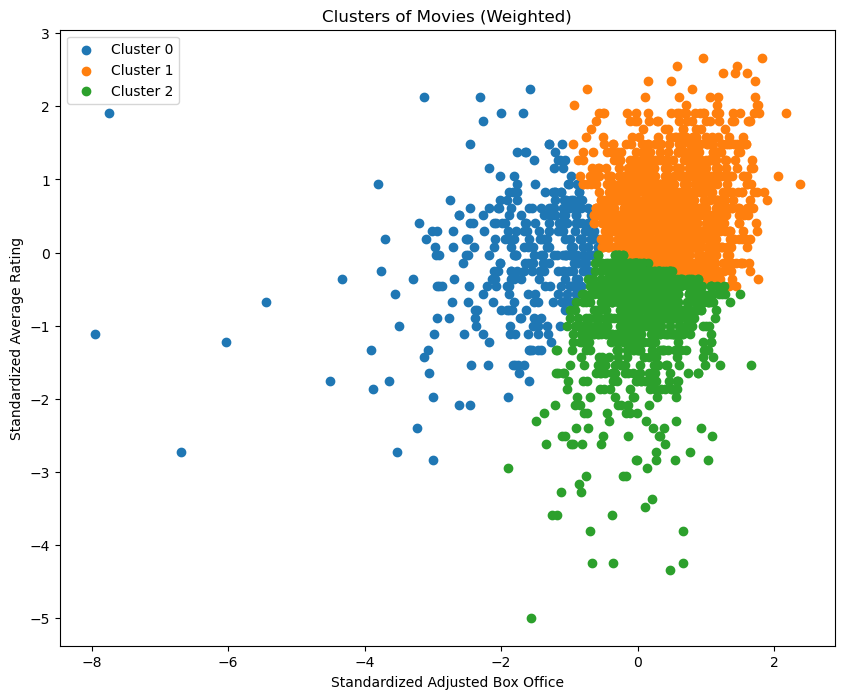

In [7]:
# Visualize clusters
plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_points = scaled_data[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

plt.xlabel('Standardized Adjusted Box Office')
plt.ylabel('Standardized Average Rating')
plt.title('Clusters of Movies based on Rating and Box Office revenue')
plt.legend()
plt.show()




## Analyze

In [8]:
# Compute cluster characteristics
for cluster in range(optimal_k):
    cluster_movies = movie_df[movie_df['Cluster'] == cluster]
    print(f"Cluster {cluster}")
    print(cluster_movies[['adjusted_box_office', 'averageRating']].describe())
    print(f"Sample movies: {cluster_movies['movie_name'].head(5).tolist()}\n")


Cluster 0
       adjusted_box_office  averageRating
count         3.450000e+02     345.000000
mean          2.595075e+06       6.282029
std           2.623688e+06       0.764071
min           2.608370e+00       3.700000
25%           5.335100e+05       5.900000
50%           1.562338e+06       6.300000
75%           3.914328e+06       6.800000
max           1.115900e+07       8.400000
Sample movies: ['jefferson in paris', 'eyes of a stranger', 'teree sang: a kidult love story', 'baadasssss!', 'quid pro quo']

Cluster 1
       adjusted_box_office  averageRating
count         1.149000e+03     1149.00000
mean          1.796075e+08        6.93020
std           2.614834e+08        0.54704
min           4.953526e+06        5.90000
25%           3.945465e+07        6.50000
50%           9.184394e+07        6.90000
75%           2.117927e+08        7.30000
max           4.022758e+09        8.80000
Sample movies: ['baby boy', 'star!', 'becoming jane', 'taxi', 'necessary roughness']

Cluster 2
 

### Cluster Analysis Based on Revenue and Ratings

Based on this analysis, it is evident that distinguishing clearly separable clusters is challenging when focusing solely on the two success metrics of our dataset (`adjusted_box_office` and `averageRating`). However, by grouping movies into clusters, we can interpret them as follows:

#### Cluster 0: "Low Revenue & Average Rating"
- **Lowest average revenue (2.6 million dollars) compared to the other clusters.**
- **Average rating is around 6.28, slightly above average but not exceptional.**

#### Cluster 1: "High Revenue & High Rating"
- **The blockbuster cluster, with the highest average revenue (179 million dollars) and high ratings (6.93 on average).**

#### Cluster 2: "Moderate Revenue & Below-Average Rating"
- **Moderate revenue (63 million dollars) compared to Cluster 0 but far below Cluster 1.**
- **Below-average ratings (5.42), indicating lower audience or critical appeal.**
